# Vizgen MERSCOPE Vizualizer Cell Clustering

In [19]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from matplotlib import pyplot as plt
import matplotlib.image as mpimg  # For displaying images
import seaborn as sns
import warnings
from observable_jupyter import embed
from clustergrammer2 import net, Network, CGM2
from scipy.stats.stats import pearsonr
from copy import deepcopy
from glob import glob

# Suppress FutureWarning messages
warnings.filterwarnings('ignore', category=FutureWarning)

C:\Users\janku\AppData\Local\Temp\ipykernel_40608\142988515.py:12: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


# Load Anndata

In [20]:
# Define file paths
select_region = "4"
base_path = f'202504111150_Sessa-p0-p7_VMSC10702/R{select_region}'
h5ad_file = os.path.join(base_path, f'202504111150_Sessa-p0-p7_VMSC10702_region_R{select_region}.h5ad')
print(h5ad_file)

# Load the .h5ad file
ad_viz = sc.read_h5ad(h5ad_file)
print(f"Successfully loaded AnnData file: {h5ad_file}")
print(ad_viz)

202504111150_Sessa-p0-p7_VMSC10702/R4\202504111150_Sessa-p0-p7_VMSC10702_region_R4.h5ad
Successfully loaded AnnData file: 202504111150_Sessa-p0-p7_VMSC10702/R4\202504111150_Sessa-p0-p7_VMSC10702_region_R4.h5ad
AnnData object with n_obs × n_vars = 44424 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'


In [21]:
# filter out blanks before clusering
keep_genes = [x for x in ad_viz.var.index.tolist() if 'Blank' not in x]
ad_viz = ad_viz[:, keep_genes]
cell_by_gene = deepcopy(ad_viz.to_df()) # copy to cell_by_gene_matrix

ad_viz

View of AnnData object with n_obs × n_vars = 44424 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Filter Cells Based on Minimum Gene Expression Counts

<Axes: >

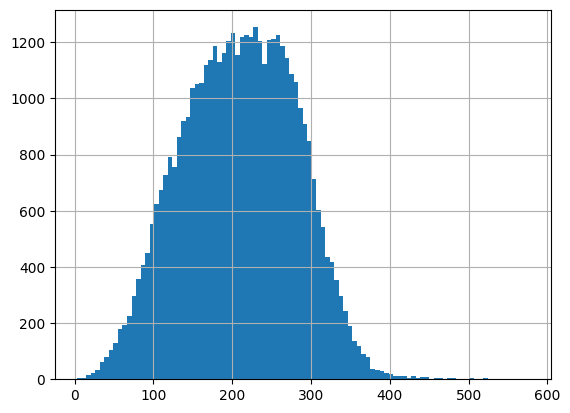

In [22]:
# before filtering
ser_exp = ad_viz.to_df().sum(axis=1)
ser_exp.hist(bins=100)

In [23]:
min_expression = 25
keep_cells = ser_exp[ser_exp > min_expression].index.tolist()
ad_viz = ad_viz[keep_cells]
ad_viz

View of AnnData object with n_obs × n_vars = 44387 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

<Axes: >

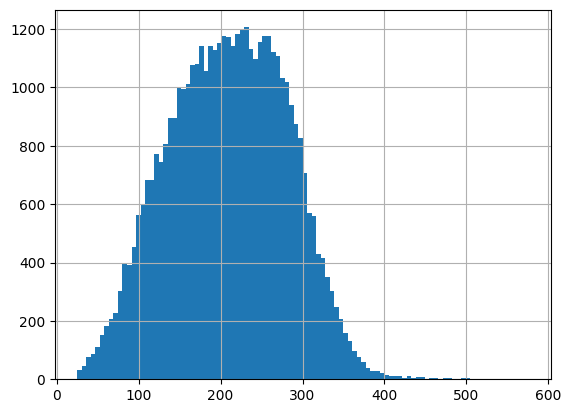

In [24]:
ser_exp = ad_viz.to_df().sum(axis=1)
ser_exp.hist(bins=100)

### Filter Cells Based on Volume

In [25]:
# ser_volume = ad_viz.obs['volume']
# ser_volume.hist(bins=100)

In [26]:
# # filter cells based on volume
# min_volume = 50
# keep_cells = ser_volume[ser_volume > min_volume].index.tolist()
# ad_viz = ad_viz[keep_cells]
# ad_viz

In [27]:
# ser_volume = ad_viz.obs['volume']
# ser_volume.hist(bins=100)

# UMAP and Single-Cell Clustering

d:\Programs\miniforge3\Lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
d:\Programs\miniforge3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


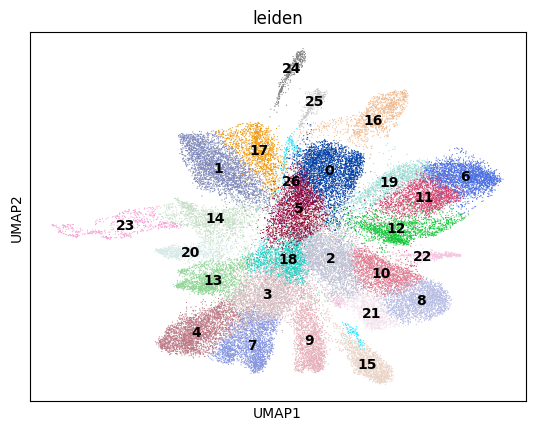

In [28]:
resolution = 1.5

# Leiden Clustering
######################

# dividing by volume instead
sc.pp.normalize_total(ad_viz)
sc.pp.log1p(ad_viz)
sc.pp.scale(ad_viz, max_value=10)
sc.tl.pca(ad_viz, svd_solver='arpack')
sc.pp.neighbors(ad_viz, n_neighbors=10, n_pcs=20)
sc.tl.umap(ad_viz)
sc.tl.leiden(ad_viz, resolution=resolution)

# Calculate Leiden Signatures
#########################################df_pos.index = [str(x) for x in list(range(df_pos.shape[0]))]
ser_counts = ad_viz.obs['leiden'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)

cat_name = 'leiden'
sig_leiden = pd.DataFrame(columns=ad_viz.var_names, index=ad_viz.obs[cat_name].cat.categories)
for clust in ad_viz.obs[cat_name].cat.categories:
    sig_leiden.loc[clust] = ad_viz[ad_viz.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ['Leiden-' + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden['leiden'] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

# generate colors for categories by plotting
sc.pl.umap(ad_viz, color="leiden", legend_loc='on data')
cats = ad_viz.obs['leiden'].cat.categories.tolist()
colors = list(ad_viz.uns['leiden_colors'])
cat_colors = dict(zip(cats, colors))

# colors for clustergrammer2
ser_color = pd.Series(cat_colors)
ser_color.name = 'color'
df_colors = pd.DataFrame(ser_color)
df_colors.index = ['Leiden-' + str(x) for x in df_colors.index.tolist()]

df_colors.loc[''] = 'white'

# Save AnnData
After saving the anndata, use the Files tab to download the `.hdf5` to your local computer. This file can then be loaded into the MERSCOPE Vizualizer where the `leiden` clusters and UMAP dimensionality reduction embedding can be imported.

In [29]:
ad_viz

AnnData object with n_obs × n_vars = 44387 × 960
    obs: 'volume', 'center_x', 'center_y', 'n_counts', 'n_genes', 'leiden'
    var: 'mean', 'std'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
# Create clustered filename based on the original h5ad file
clustered_filename = h5ad_file.replace('.h5ad', '_clustered.h5ad')
ad_viz.write_h5ad(clustered_filename)
print(f"Saved clustered data to: {clustered_filename}")

Saved clustered data to: 202504111150_Sessa-p0-p7_VMSC10702/R4\202504111150_Sessa-p0-p7_VMSC10702_region_R4_clustered.h5ad
